### Extract SPF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#csv_files = os.listdir('data/SPF_individual_forecasts/')
csv_files = os.listdir('/Users/JABAMI/Desktop/Cours_Sorbonne_FTD/Quantitative_Methods/devoir/rep_vuln_growth/data/SPF_individual_forecasts/')

In [2]:
def convert_to_date(file, df, year):

    # Extract the quarter based on the file naming logic
    quarter = int(file[5:6])
   
    # Here I want to extract YoY
    if quarter == 1:
        df = df.loc[df['TARGET_PERIOD'] == f"{year}", :]
        df['Date'] = pd.to_datetime(f"{year}-12-01")
    elif quarter == 2:
        df = df.loc[df['TARGET_PERIOD'] == f"{year}", :]
        df['Date'] = pd.to_datetime(f"{year+1}-03-01")
    elif quarter == 3:
        df = df.loc[df['TARGET_PERIOD'] == f"{year+1}", :]
        df['Date'] = pd.to_datetime(f"{year+1}-06-01")
    elif quarter == 4:
        df = df.loc[df['TARGET_PERIOD'] == f"{year+1}", :]
        df['Date'] = pd.to_datetime(f"{year+1}-09-01")

    return df

In [3]:
# Define a function to capture lines of interest
def extract_growth_expectations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
   
    # Initialize variables for storing relevant lines
    extract_lines = False
    growth_data = []

    for line in lines:
        # Check for the target line to start extraction
        if "GROWTH EXPECTATIONS; YEAR-ON-YEAR CHANGE IN REAL GDP" in line: #Pour récupérer les forecast pour real GDP
            extract_lines = True
            continue
       
        # Stop extraction when an empty line is encountered
        if extract_lines:
            if line.strip() == "":
                break
            growth_data.append(line.strip())
   
    # Convert the list of extracted lines to a DataFrame
    if growth_data:
        growth_df = pd.DataFrame([row.split(",") for row in growth_data])
        # First line as column names
        # Set the first row as the header (column names)
        growth_df.columns = growth_df.iloc[0]
       
        # Drop the first row from the DataFrame
        growth_df = growth_df.drop(0).reset_index(drop=True)
        # convert to numeric
        if '' in growth_df.columns:
            del growth_df['']
        for coli in growth_df.columns:
            if coli != 'TARGET_PERIOD':
                growth_df[coli] = pd.to_numeric(growth_df[coli], errors='coerce')
        # Find the first empty row to determine where to stop
        # Identify the columns to check for null values, excluding 'TARGET_PERIOD'
        columns_to_check = growth_df.columns.difference(['TARGET_PERIOD'])
       
        # Find the first row where all values are NaN in the specified columns
        empty_line_index = growth_df[growth_df[columns_to_check].isna().all(axis=1)].index[0]

        # Keep all rows up until the empty line
        growth_df = growth_df.iloc[:empty_line_index, :]
        return growth_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data is found

In [4]:
# Initialize an empty DataFrame to store results across all files
df_panel = pd.DataFrame()

# Loop through each CSV file and process
for file in csv_files:
    #if file != '2024Q4.csv' : #[4:6]  #filtered_df = growth_df.loc[growth_df['TARGET_PERIOD'] == '2025']
        file_path = f'/Users/JABAMI/Desktop/Cours_Sorbonne_FTD/Quantitative_Methods/devoir/rep_vuln_growth/data/SPF_individual_forecasts/{file}'
    
        # Extract growth expectations data from each file
        growth_df = extract_growth_expectations(file_path)
    
        # If growth data exists, process further
        if not growth_df.empty:
            year = int(file[:4])  # Assuming the year is at the start of the filename
            growth_df = convert_to_date(file, growth_df, year)  # Process with existing logic
            df_panel = pd.concat([df_panel, growth_df], ignore_index=True)


df_panel.dropna(inplace=True, how='all', axis=1)
df_panel.dropna(inplace=True, how='all', axis=0)


# Dictionary mapping columns to significance
column_significance_map = {
    'TN15_0':']-inf,-15]',
    'TN6_0':']-inf,-6]',
    'TN4_0': ']-inf, - 4]',
    'TN2_0': ']-inf, - 2]',
    'TN1_0': ']-inf, -1]',
    'T0_0': ']-inf, -0]',
    'FN15_0TN13_1':'[-15,-13]',
    'FN13_0TN11_1':'[-13,-11]',
    'FN11_0TN9_1':'[-11,-9]',
    'FN9_0TN7_1':'[-9,-7]',
    'FN7_0TN5_1':'[-7,-5]',
    'FN6_0TN5_6':'[-6,-5.5]',
    'FN5_5TN5_1':'[-5.5,-5]',
    'FN5_0TN4_6':'[-5,-4.5]',
    'FN4_5TN4_1':'[-4.5,-4]',
    'FN5_0TN3_1':'[-5,-3]',
    'FN3_0TN1_1':'[-3,-1]',
    'FN4_0TN3_6': '[-4,-3.5]',
    'FN3_5TN3_1': '[-3.5,-3.1]',
    'FN3_0TN2_6': '[-3,-2.5]',
    'FN2_5TN2_1': '[-2.5,-2.1]',
    'FN2_0TN1_6': '[-2,-1.5]',
    'FN1_5TN1_1': '[-1.5,-1.1]',
    'FN1_0TN0_6': '[-1,-0.5]',
    'FN0_5TN0_1': '[-0.5,-0.1]',
    'F0_0T0_4': '[0,0.5]',
    'F0_5T0_9': '[0.5,1]',
    'F1_0T1_4': '[1,1.5]',
    'F1_5T1_9': '[1.5,2]',
    'F2_0T2_4': '[2,2.5]',
    'F2_5T2_9': '[2.5,3]',
    'F3_0T3_4': '[3,3.5]',
    'F3_5T3_9': '[3.5,4]',
    'F4_0T4_4': '[4.0,4.5]',
    'F4_0T5_9':'[4,6]',
    'F6_0T7_9':'[6,8]',
    'F4_5T4_9': '[4.5,5]',
    'F8_0T9_9': '[8, 10]',
    'F10_0': '[10,+inf[',
    'F3_5': '[3.5,+inf[',
    'F4_0': '[4,+inf[',
    'F5_0': '[5,+inf['
}


# Rename the columns in the DataFrame based on the dictionary
df_panel.rename(columns=column_significance_map, inplace=True)


# order the columns
df_panel = df_panel.loc[:,['Date', 'FCT_SOURCE', 'POINT', ']-inf,-15]', ']-inf,-6]', ']-inf, -1]',
       ']-inf, -0]', '[-15,-13]', '[-13,-11]', '[-11,-9]', '[-9,-7]',
       '[-7,-5]', '[-6,-5.5]', '[-5.5,-5]', '[-5,-4.5]','[-5,-3]','[-4.5,-4]',
       '[-4,-3.5]', '[-3.5,-3.1]', '[-3,-2.5]','[-3,-1]', '[-2.5,-2.1]', '[-2,-1.5]',
       '[-1.5,-1.1]','[-1,-0.5]',  '[-0.5,-0.1]',  
       '[0,0.5]', '[0.5,1]', '[1,1.5]', '[1.5,2]', '[2,2.5]', '[2.5,3]',
       '[3,3.5]', '[3.5,4]', '[4.0,4.5]', '[4.5,5]','[4,6]', '[6,8]', '[8, 10]', '[5,+inf[',
       '[4,+inf[', '[10,+inf[' ]]

df_panel.sort_values(by='Date', inplace=True)

C:\Users\JABAMI\AppData\Local\Temp\ipykernel_20012\4097535813.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(f"{year}-12-01")
C:\Users\JABAMI\AppData\Local\Temp\ipykernel_20012\4097535813.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(f"{year+1}-03-01")
C:\Users\JABAMI\AppData\Local\Temp\ipykernel_20012\4097535813.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [5]:
# To keep only what interest us. 
df_panel = df_panel[['Date', 'FCT_SOURCE', 'POINT']]

In [6]:
# I pivot the table to have the forecasters as columns name. 
df_pivot = df_panel.pivot_table(index='Date', columns='FCT_SOURCE', values='POINT', aggfunc='first')

In [7]:
# Mean and median (YoY)
df_pivot['SPF_Mean'] = df_pivot.mean(axis=1)
df_pivot['SPF_Median'] = df_pivot.median(axis=1)

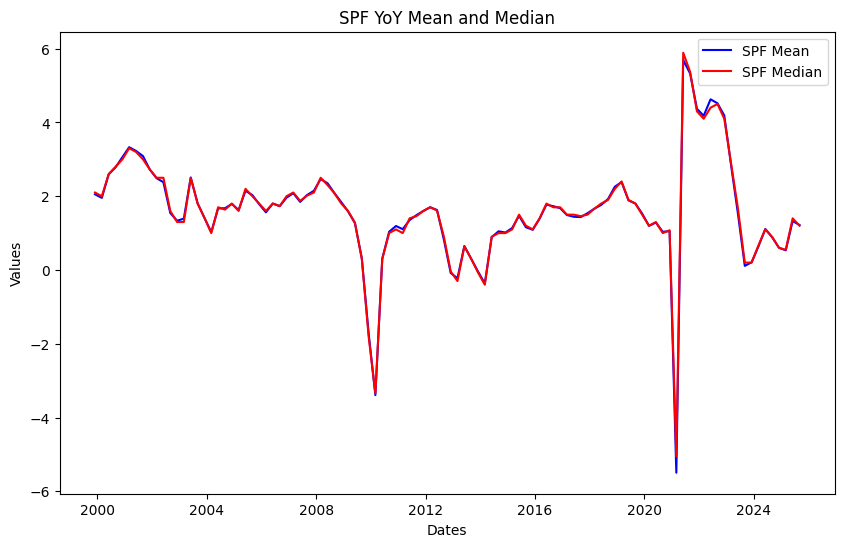

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df_pivot.index, df_pivot['SPF_Mean'], label='SPF Mean', color='blue')
plt.plot(df_pivot.index, df_pivot['SPF_Median'], label='SPF Median', color='red')
plt.title('SPF YoY Mean and Median')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.legend()
plt.show()

### Out-of-Sample PIT Calculation and Specification Test With SPF Mean and Median 

In [9]:
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import t
import matplotlib.pyplot as plt

# Set the working directory
os.chdir('/Users/JABAMI/Desktop/Cours_Sorbonne_FTD/Quantitative_Methods/devoir/rep_vuln_growth/')

# Set a limit for minimization iterations
minimize_iter_max = 100

In [10]:
# Function to compute the quantile for the skewed t-distribution
def qskt(p, mu, sigma, alpha, nu):
    """
    Calculate the quantile for the skewed t-distribution.
    """
    quantile = mu + sigma * t.ppf(p, df=nu) * (1 + alpha * np.sign(p - 0.5))
    return quantile

# Function to compute the quantile for the skewed t-distribution
def qskt(p, mu, sigma, alpha, nu):
    """
    Calculate the quantile for the skewed t-distribution.
    """
    quantile = mu + sigma * t.ppf(p, df=nu) * (1 + alpha * np.sign(p - 0.5))
    return quantile

# Function to perform quantile interpolation for skewed t-distribution
def quantiles_interpolation(quantiles, quantile_targets):
    """
    Fit the parameters of the skewed t-distribution to the provided quantiles.
    """
    def objective(params):
        mu, sigma, alpha, nu = params
        theoretical_quantiles = [qskt(q, mu, sigma, alpha, nu) for q in quantile_targets]
        error = np.sum((np.array(theoretical_quantiles) - np.array(quantiles)) ** 2)
        return error

    initial_guess = [0, 1, 0, 5]
    bounds = [(-np.inf, np.inf), (1e-6, np.inf), (-np.inf, np.inf), (2, np.inf)]
    result = minimize(objective, initial_guess, bounds=bounds, options={'maxiter': minimize_iter_max})
    mu, sigma, alpha, nu = result.x
    return mu, sigma, alpha, nu

# Function to calculate the cumulative distribution function of the skewed t-distribution
def pskt(x, mu, sigma, alpha, nu):
    """
    Calculate the cumulative distribution function (CDF) for the skewed t-distribution.
    """
    z = (x - mu) / sigma
    cdf_value = t.cdf(z * (1 + alpha * np.sign(z)), df=nu)
    return cdf_value

# Function to calculate the empirical CDF of PIT values
def empirical_cdf(pit_values, rvec):
    """
    Compute the empirical cumulative distribution function (CDF) of the PIT values.
    """
    sorted_pits = np.sort(pit_values)
    empirical_cdf_values = np.searchsorted(sorted_pits, rvec, side='right') / len(sorted_pits)
    return empirical_cdf_values

In [11]:
# To match the dates of df
df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot.index = df_pivot.index.to_series().apply(lambda x: x.replace(month=1) if x.month == 3 else x)
df_pivot.index = df_pivot.index.to_series().apply(lambda x: x.replace(month=4) if x.month == 6 else x)
df_pivot.index = df_pivot.index.to_series().apply(lambda x: x.replace(month=7) if x.month == 9 else x)
df_pivot.index = df_pivot.index.to_series().apply(lambda x: x.replace(month=10) if x.month == 12 else x)

In [12]:
# Load the data
df = pd.read_excel('data/Data_Adrian_2019_usa&EA.xlsx', sheet_name='EA_Quarterly')
df_pivot = df_pivot.reset_index()
mean_forecast = df_pivot[['Date', 'SPF_Mean']]
median_forecast = df_pivot[['Date', 'SPF_Median']]

# Create a 'Date' column from 'YEAR' and 'QUARTER' for mean and median forecasts
#mean_forecast['Date'] = pd.to_datetime(mean_forecast['YEAR'].astype(str) + 'Q' + mean_forecast['QUARTER'].astype(str))
#median_forecast['Date'] = pd.to_datetime(median_forecast['YEAR'].astype(str) + 'Q' + median_forecast['QUARTER'].astype(str))

# Set the Date as the index for merging
mean_forecast.set_index('Date', inplace=True)
median_forecast.set_index('Date', inplace=True)
# Process the main dataframe
df.index = pd.to_datetime(df['Date'])
df.sort_index(inplace=True)
df = df.drop(columns=['Date'])
df['Intercept'] = 1

In [13]:
# Merge the main dataframe with the mean and median SPF forecast on the Date index
df = df.merge(mean_forecast[['SPF_Mean']], left_index=True, right_index=True, how='left')
# Rename columns for clarity
df.rename(columns={'SPF_Mean': 'SPF_mean_forecast'}, inplace=True)
df = df.merge(median_forecast[['SPF_Median']], left_index=True, right_index=True, how='left')
df.rename(columns={'SPF_Median': 'SPF_median_forecast'}, inplace=True)
df = df.dropna(subset=['SPF_mean_forecast', 'SPF_median_forecast'])

c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\JABAMI\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum nu

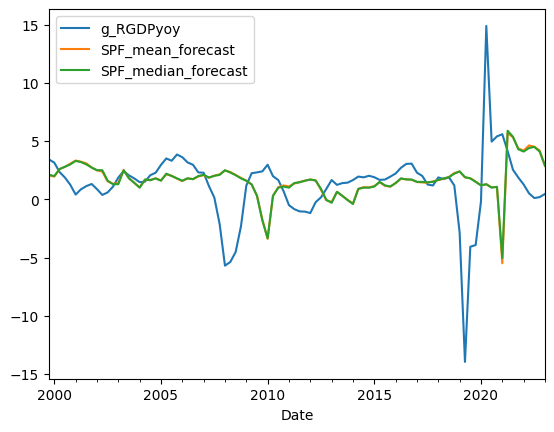

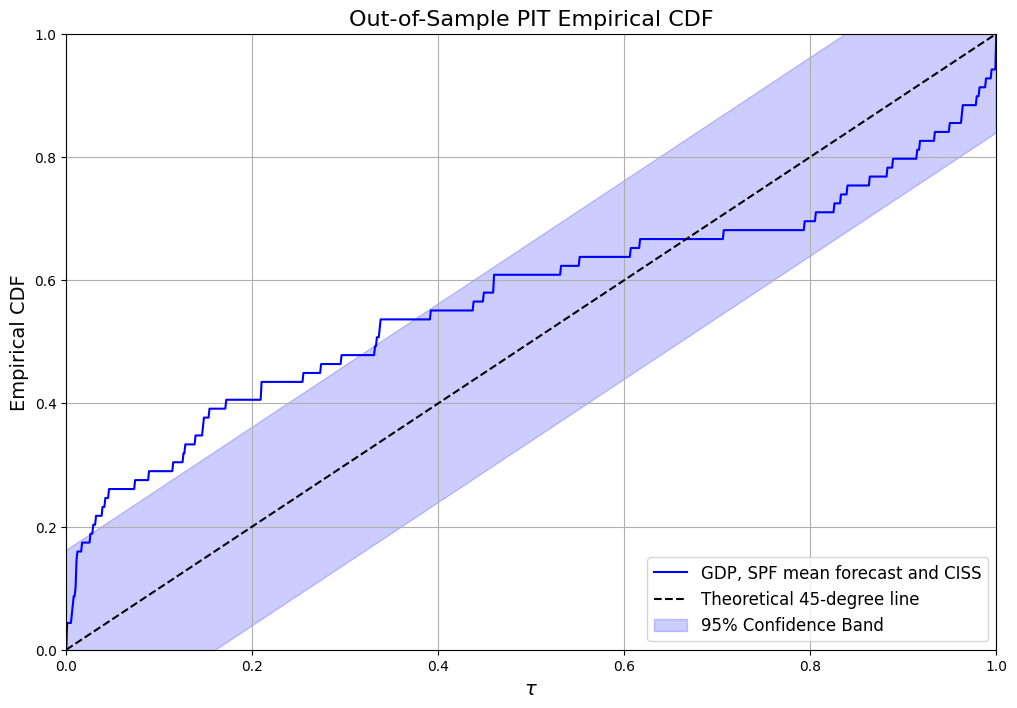

In [14]:
# Define forecasting horizon
h = 4  # Set to 4 for YoY  prediction
ycol = 'g_RGDP' if h == 1 else 'g_RGDPyoy'
df['g_RGDP_original'] = df[ycol]
df[ycol] = df[ycol].shift(-h)
df.dropna(subset=['CISS', ycol, 'g_RGDP_original'], inplace=True)

df.loc[:,[ycol,'SPF_mean_forecast','SPF_median_forecast']].plot()


# Determine the starting index for out-of-sample prediction
jtFirstOOS = df.index.get_loc(pd.Timestamp('2006-01-01'))

# Out-of-Sample Quantile Regression with CISS and GDP
rolling_window_size = 25
quantile_levels = [0.05, 0.25, 0.5, 0.75, 0.95]
T_oos = len(df) - jtFirstOOS

quantile_fitted_oos = np.zeros((T_oos, len(quantile_levels)))

# Perform quantile regression with a rolling window approach
for ti in range(jtFirstOOS, len(df)):
    # Use data up to the current time step `ti` (rolling window)
    train_df = df.iloc[ti - rolling_window_size:ti]
    X_train = sm.add_constant(train_df[['CISS', 'g_RGDP_original','SPF_mean_forecast']])
    y_train = train_df[ycol]

    # Estimate quantiles for each quantile level
    for i, q in enumerate(quantile_levels):
        quantile_model = sm.QuantReg(y_train, X_train).fit(q=q)
        quantile_fitted_oos[ti - jtFirstOOS, i] = quantile_model.predict([1, df['CISS'].iloc[ti], df['g_RGDP_original'].iloc[ti],df['SPF_mean_forecast'].iloc[ti]])[0]

# Fit Skewed t-Distribution for each out-of-sample time step
tdist_mu_oos = np.zeros(T_oos)
tdist_sigma_oos = np.zeros(T_oos)
tdist_alpha_oos = np.zeros(T_oos)
tdist_nu_oos = np.zeros(T_oos)

quantile_targets = [0.05, 0.25, 0.75, 0.95]

# Fit skewed-t distribution using the quantile estimates
for ti in range(T_oos):
    quantiles_to_fit = quantile_fitted_oos[ti, [0, 1, 3, 4]]
    mu, sigma, alpha, nu = quantiles_interpolation(quantiles_to_fit, quantile_targets)
    tdist_mu_oos[ti], tdist_sigma_oos[ti], tdist_alpha_oos[ti], tdist_nu_oos[ti] = mu, sigma, alpha, nu

# Calculate PIT values
def calculate_pits_oos(y_true, params):
    """
    Calculate the Probability Integral Transform (PIT) values for out-of-sample data.
    """
    pits = np.zeros(len(y_true))
    for i in range(len(y_true)):
        mu, sigma, alpha, nu = params[i]
        pits[i] = pskt(y_true[i], mu, sigma, alpha, nu)
    return pits

# Generate PITs for out-of-sample predictions
y_oos = df[ycol].iloc[jtFirstOOS:].values
skewed_t_params_oos = [(tdist_mu_oos[i], tdist_sigma_oos[i], tdist_alpha_oos[i], tdist_nu_oos[i]) for i in range(T_oos)]
pits_skewed_t_oos = calculate_pits_oos(y_oos, skewed_t_params_oos)

# Set rvec for plotting
rvec = np.arange(0, 1.001, 0.001)

# Calculate empirical CDF for the PIT values
zST_ecdf = empirical_cdf(pits_skewed_t_oos, rvec)

# Determine critical values for the PIT test
kappa = 1.34  # Asymptotic critical value for h=1

# Plot the PITs empirical CDF vs. theoretical CDF
plt.figure(figsize=(12, 8))
plt.plot(rvec, zST_ecdf, '-b', label='GDP, SPF mean forecast and CISS')
plt.plot(rvec, rvec, 'k--', label='Theoretical 45-degree line')
plt.fill_between(rvec, rvec - (kappa / np.sqrt(len(pits_skewed_t_oos))), 
                 rvec + (kappa / np.sqrt(len(pits_skewed_t_oos))), color='b', alpha=0.2, label='95% Confidence Band')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel('Empirical CDF', fontsize=14)
plt.title('Out-of-Sample PIT Empirical CDF', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()


### Ranking of the forecasters

In [15]:
#df_rank = df_pivot.loc[:, df_pivot.isnull().sum() <= 20]
#df_rank = df_rank.dropna()

In [16]:
from sklearn.metrics import mean_squared_error

df_pivot.set_index('Date', inplace=True)
# I remove the forecaster that have not published a forecast more than 70 times
df_pivot = df_pivot.loc[:, df_pivot.isnull().sum() <= 70]

mse_dict = {}

for forecaster in df_pivot.columns:
    aligned = pd.concat([df['g_RGDPyoy'], df_pivot[forecaster]], axis=1).dropna()
    
    if not aligned.empty:
        mse = mean_squared_error(aligned['g_RGDPyoy'], aligned[forecaster])
        mse_dict[forecaster] = mse
    else:
        mse_dict[forecaster] = float('Not Enough Values')

In [17]:
# Sort the forecasters from the more precise to the least precise
sorted_mse = sorted(mse_dict.items(), key=lambda item: item[1])

# this is a ranking whitout considering the forecaster that haven't published more than 70 times as stated above. 
for forecaster, mse in sorted_mse:
    print(f"Forecaster: {forecaster}, MSE: {mse}")

Forecaster: 70.0, MSE: 4.969843041362824
Forecaster: 92.0, MSE: 5.119328995946398
Forecaster: 84.0, MSE: 5.320782935583583
Forecaster: 57.0, MSE: 5.907399980050881
Forecaster: 31.0, MSE: 6.298057520922174
Forecaster: 59.0, MSE: 6.444805102369016
Forecaster: 35.0, MSE: 6.472500837536471
Forecaster: 11.0, MSE: 7.162040120731266
Forecaster: 42.0, MSE: 7.173142932776706
Forecaster: 105.0, MSE: 7.308519583247487
Forecaster: 3.0, MSE: 7.605903715176034
Forecaster: 73.0, MSE: 7.989622730364739
Forecaster: 1.0, MSE: 8.199725584566632
Forecaster: 5.0, MSE: 8.294560374178916
Forecaster: 19.0, MSE: 8.461533125775027
Forecaster: 94.0, MSE: 8.802156689866093
Forecaster: 36.0, MSE: 8.9944034273246
Forecaster: 90.0, MSE: 9.104804466156825
Forecaster: 29.0, MSE: 9.218351982933145
Forecaster: 54.0, MSE: 9.293327086088135
Forecaster: 45.0, MSE: 9.504817254548474
Forecaster: 49.0, MSE: 10.91613728347713
Forecaster: 37.0, MSE: 11.037226827340753
Forecaster: 67.0, MSE: 11.116940260679922
Forecaster: 4.0, M